# Deplyment of semi unsupervised learning on ATLAS OpenData
### Testing of reading in data and trying an auto encoder
Remember to install the necessary api's for usage in Galaxy

In [1]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install scikit-plot

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras_tuner as kt
import plot_set
import os
seed = tf.random.set_seed(1)
#import ROOT as R
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:


df_atlas = pd.read_hdf("/storage/shared/data/2lep_df_forML_data_fromRDF.hdf5")
df = pd.read_hdf("/storage/shared/data/2lep_df_forML_bkg_signal_fromRDF.hdf5")


#weights = pd.read_csv("weights.csv")

In [3]:
df.info()
df_atlas.info()
#weights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109683372 entries, 0 to 109683371
Data columns (total 39 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   njet20                     int32  
 1   njet60                     int32  
 2   nbjet60                    int32  
 3   nbjet70                    int32  
 4   nbjet77                    int32  
 5   nbjet85                    int32  
 6   isOS                       int32  
 7   isSF                       int32  
 8   mll                        float32
 9   mt2                        float32
 10  met_et                     float32
 11  met_phi                    float32
 12  lep1_flav                  int32  
 13  lep1_pt                    float32
 14  lep1_eta                   float32
 15  lep1_phi                   float32
 16  lep1_E                     float32
 17  lep1_ptcone30              float32
 18  lep1_etcone20              float32
 19  lep1_trackd0pvunbiased     float32
 20

In [4]:
df["physdescr"]

0                            Zee
1                            Zee
2                            Zee
3                            Zee
4                            Zee
                    ...         
109683367    Zee_PTV0_70_BFilter
109683368    Zee_PTV0_70_BFilter
109683369    Zee_PTV0_70_BFilter
109683370    Zee_PTV0_70_BFilter
109683371    Zee_PTV0_70_BFilter
Name: physdescr, Length: 109683372, dtype: object

### Adding more columns 
Because the dataset is lacking the "isSignal" and "weight" columns, we have to create them our self

In [5]:
df["category"].unique()

array(['Zjetsincl', 'Zjets', 'Diboson', 'Higgs', 'singleTop', 'topX',
       'RS_G_ZZ', 'SUSYC1N2', 'Wjets', 'SUSYC1C1', 'dmV_Zll', 'ttbar',
       'GG_ttn1', 'ZPrimett', 'Gee', 'SUSYSlepSlep', 'ZPrimeee',
       'ZPrimemumu', 'Wjetsincl', 'Gmumu', 'TT_directTT'], dtype=object)

In [6]:
signals = ['ZPrimemumu', 'SUSYC1C1', 'RS_G_ZZ', 'SUSYSlepSlep', 'SUSYC1N2', 'ZPrimett', 'ZPrimeee', 'dmV_Zll', 'GG_ttn1', 'TT_directTT', 'Gee', 'Gmumu']

In [7]:
issignal = np.where(df["category"].isin(signals)  , 1, 0)

In [8]:
df = df.assign(isSignal=issignal)

In [9]:
df.head(2)

,njet20,njet60,nbjet60,nbjet70,nbjet77,nbjet85,isOS,isSF,mll,mt2,...,lep2_trackd0pvunbiased,lep2_tracksigd0pvunbiased,lep2_isTightID,lep2_z0,channelNumber,costhstar,weight,category,physdescr,isSignal
0,0,0,0,0,0,0,1,1,83241.078125,203008.812500,...,-0.022843,0.767920,1.0,0.000382,361106,0.113907,0.127318,Zjetsincl,Zee,0
1,1,0,0,0,0,0,1,1,91189.015625,115910.992188,...,-0.001654,0.100329,1.0,-0.136329,361106,0.864449,0.114645,Zjetsincl,Zee,0


Remove W jets include and Z jets include

In [10]:
zjetsinl_idx = df[df["category"] == "Zjetsincl"].index
wjetsinl_idx = df[df["category"] == "Wjetsincl"].index

In [11]:
df.drop(zjetsinl_idx ,inplace=True)
df.drop(wjetsinl_idx ,inplace=True)

In [12]:
df_atlas.head(2)


,njet20,njet60,nbjet60,nbjet70,nbjet77,nbjet85,isOS,isSF,mll,mt2,...,lep2_E,lep2_ptcone30,lep2_etcone20,lep2_trackd0pvunbiased,lep2_tracksigd0pvunbiased,lep2_isTightID,lep2_z0,channelNumber,costhstar,weight
0,1,0,0,0,0,0,1,1,12510.837891,57409.433594,...,10032.247070,1196.712769,-92.074127,-0.000793,0.044793,1.0,-0.024559,300800,0.131353,1.0
1,1,0,0,0,0,0,1,1,91430.445312,192062.109375,...,192062.109375,0.000000,-174.402069,0.003242,0.373168,1.0,-0.064178,300800,0.323297,1.0


### Data separation

In [13]:
categories = df["category"]

background_categories = df[df["isSignal"] == 0]["category"].unique()
signal_df = df[df['category'] == 'SUSYC1C1']

background_df = df[df["isSignal"] == 0]

columns_to_drop = ["category", "isSignal", "physdescr"]


signal_df.drop(columns_to_drop, axis=1, inplace=True)
background_df.drop(columns_to_drop, axis=1, inplace=True)


signal_mc = signal_df#.to_numpy()
background_mc = background_df#.to_numpy()

data = df_atlas

/storage/software/easybuild/software/SciPy-bundle/2020.11-fosscuda-2020b/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Plot to check somewhat agreement with data and MC

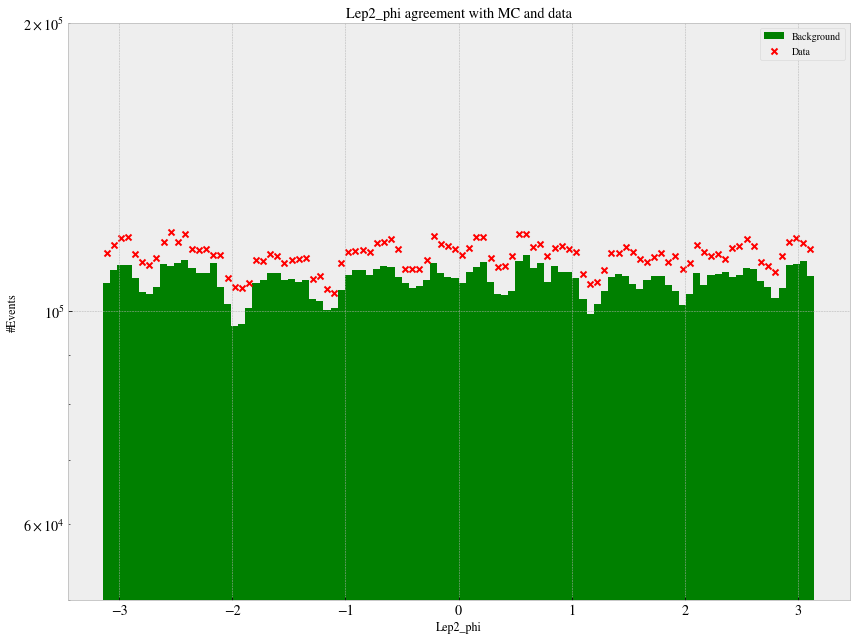

In [14]:
histo_b = background_df["lep2_phi"]
histo_data = data["lep2_phi"]
weight_histo = background_df["weight"]
                
plt.rcParams["figure.figsize"] = (12,9)
fig, ax = plt.subplots()

N, bins = np.histogram(histo_data, bins = 100)
x = (np.array(bins[0:-1]) + np.array(bins[1:]))/2

n_bins= 100
colors = ["green"]
labels= ["Background"]
ax.hist(histo_b, 
        n_bins,   
        histtype='bar', 
        color=colors, 
        label=labels, 
        weights=weight_histo
        )

ax.scatter(x, N, marker="x", color="red",label="Data")

ax.legend(prop={'size': 10})
ax.set_title('Lep2_phi agreement with MC and data')
ax.set_xlabel('Lep2_phi')
ax.set_ylabel('#Events')
ax.set_yscale('log')
ax.set_ylim([5e4, 2e5])

fig.tight_layout()
#plt.savefig("b_s_recon.pdf")
plt.show()

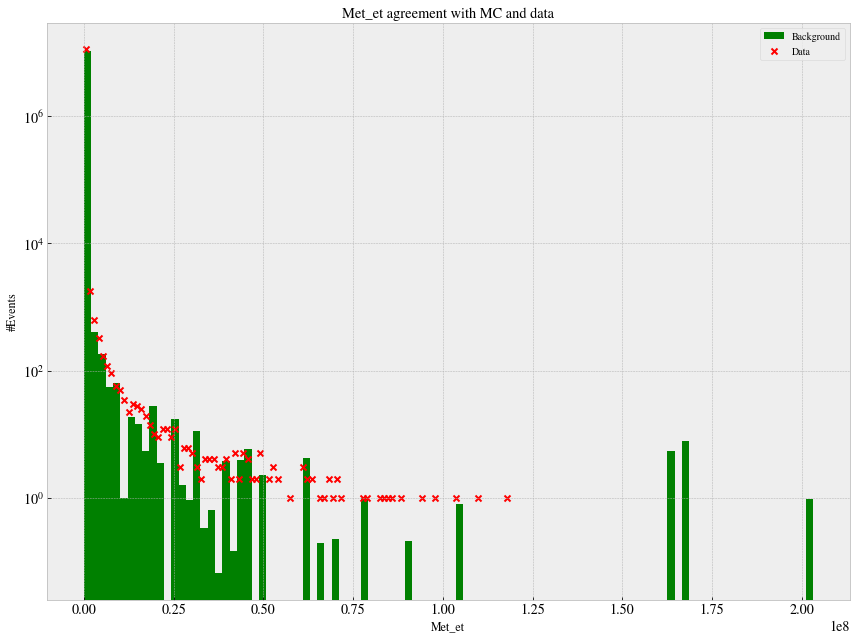

In [15]:
histo_b = background_df["met_et"]
histo_data = data["met_et"]

weight_histo = background_df["weight"]
                
plt.rcParams["figure.figsize"] = (12,9)
fig, ax = plt.subplots()

N, bins = np.histogram(histo_data, bins = 100)
x = (np.array(bins[0:-1]) + np.array(bins[1:]))/2

n_bins= 100
colors = ["green"]
labels= ["Background"]
ax.hist(histo_b, 
        n_bins,   
        histtype='bar', 
        color=colors, 
        label=labels, 
        weights=weight_histo
        )

ax.scatter(x, N, marker="x", color="red",label="Data")

ax.legend(prop={'size': 10})
ax.set_title('Met_et agreement with MC and data')
ax.set_xlabel('Met_et')
ax.set_ylabel('#Events')
ax.set_yscale('log')
#ax.set_ylim([5e4, 2e5])

fig.tight_layout()
#plt.savefig("b_s_recon.pdf")
plt.show()

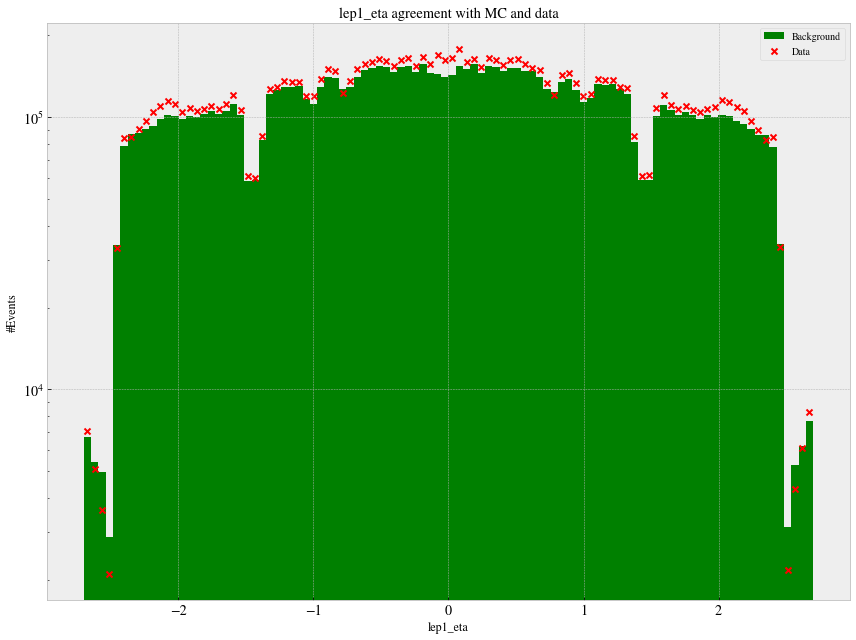

In [16]:
histo_b = background_df["lep1_eta"]
histo_data = data["lep1_eta"]

weight_histo = background_df["weight"]
                
plt.rcParams["figure.figsize"] = (12,9)
fig, ax = plt.subplots()

N, bins = np.histogram(histo_data, bins = 100)
x = (np.array(bins[0:-1]) + np.array(bins[1:]))/2

n_bins= 100
colors = ["green"]
labels= ["Background"]
ax.hist(histo_b, 
        n_bins,   
        histtype='bar', 
        color=colors, 
        label=labels, 
        weights=weight_histo
        )

ax.scatter(x, N, marker="x", color="red",label="Data")

ax.legend(prop={'size': 10})
ax.set_title('lep1_eta agreement with MC and data')
ax.set_xlabel('lep1_eta')
ax.set_ylabel('#Events')
ax.set_yscale('log')
#ax.set_ylim([5e4, 2e5])

fig.tight_layout()
#plt.savefig("b_s_recon.pdf")
plt.show()

In [17]:
print(np.shape(background_mc))
print(np.shape(signal_mc))
print(np.shape(data))


(63642138, 37)
(135127, 37)
(11442336, 37)


### Data handling and preperations
Before we train on the data, we need to scale it and split it into a validation and 

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [19]:
# Split background
X_b_train, X_b_val = train_test_split(background_mc, test_size=0.2, random_state=seed)
# Split signal
#X_s_train, X_s_test = train_test_split(signal_mc, test_size=0.2, random_state=seed)

Now, combine samples for testing

In [20]:
b_train_weights = X_b_train["weight"]
b_val_weights = X_b_val["weight"]
s_test_weights = signal_mc["weight"]

data_weights = data["weight"]

X_b_train.pop("weight")
X_b_val.pop("weight")
signal_mc.pop("weight")
data.pop("weight")


X_s_test = signal_mc


X_test = np.concatenate((X_b_val,X_s_test),0)

y_b_val = np.zeros(X_b_val.shape[0])                                                                                                                                                                                                                                                   
y_s_test = np.ones(X_s_test.shape[0])      
y_test = np.concatenate((y_b_val,y_s_test),0)

### Find that weights correct for sample size

In [21]:
sum_weight = np.concatenate((b_train_weights, b_val_weights), 0)
sum_weight = np.sum(sum_weight)

In [22]:
print(sum_weight) 
diff = abs(data.shape[0]- sum_weight)
print(diff/data.shape[0]*100)

10785795.65977304
5.737817349769832


In [23]:
print(np.shape(X_b_train))
print(np.shape(X_s_test))
print(np.shape(data))

(50913710, 36)
(135127, 36)
(11442336, 36)


In [24]:
#strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

#with strategy.scope():

scaler_ae = MinMaxScaler()#StandardScaler()#MinMaxScaler()
X_b_train = scaler_ae.fit_transform(X_b_train)                                                                                                                                                                                                                        
X_b_val= scaler_ae.transform(X_b_val)                                                                                                                                                                                                                                 
X_s_test = scaler_ae.transform(X_s_test)
data = scaler_ae.transform(data)
#X_test = scaler_ae.transform(X_test)

In [25]:
data_shape = np.shape(X_b_train)[1]
number_of_rows = np.shape(X_b_train)[0]
n_vali = np.shape(X_b_val)[0]

random_indices_b = np.random.choice(number_of_rows, size=int(2e6), replace=False)
test_indices_b = np.random.choice(n_vali, size=int(400000), replace=False)

smaller_data = X_b_train[random_indices_b, :]
small_vali = X_b_val[test_indices_b, :]


test_indices_sb = np.random.choice(np.shape(X_test)[0], size=int(200000), replace=False)
X_small_test = X_test[test_indices_sb, :]

in_and_out = X_b_train.shape[0]

Try to load data faster

In [26]:
#X_b_train = tf.data.Dataset.from_tensor_slices((X_b_train, X_b_train))
#X_b_val = tf.data.Dataset.from_tensor_slices((X_b_val, X_b_val))
#X_s_test = tf.data.Dataset.from_tensor_slices((X_s_test, X_s_test))
#data = tf.data.Dataset.from_tensor_slices((data, data))
#smaller_data = tf.data.Dataset.from_tensor_slices((smaller_data, smaller_data))
#small_vali = tf.data.Dataset.from_tensor_slices((small_vali, small_vali))

### Training
Now we can train on the data

In [65]:
tf.config.optimizer.set_jit( "autoclustering")
def gridautoencoder(X_b, X_back_test):
    tuner = kt.Hyperband(
        AE_model_builder,
        objective=kt.Objective("val_mse", direction="min"),
        max_epochs=50,
        factor=3,
        directory="GridSearches",
        project_name="AE",
        overwrite=True,
    )

    tuner.search(X_b, X_b, epochs=17, batch_size=4096,
                 validation_data=(X_back_test, X_back_test))
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(
        f"""
    
    Latent layer has {best_hps.get('num_of_neurons1')} with activation {best_hps.get('1_act')} \n
    Output activation is {best_hps.get('2_act')} \n
    
    \n
    with learning rate = {best_hps.get('learning_rate')} and alpha = {best_hps.get('alpha')} \n
    and kernel regulation = {best_hps.get("Kernel_reg")} and activation regulation = {best_hps.get("Atc_reg")}
    """
    )

    state = True
    while state == True:
        answ = input("Do you want to save model? (y/n) ")
        if answ == "y":
            name = input("name: ")
            tuner.hypermodel.build(best_hps).save(
                f"../tf_models/model_{name}.h5")
            state = False
            print("Model saved")
        elif answ == "n":
            state = False
            print("Model not saved")


def AE_model_builder(hp):
    
    ker_choice = hp.Choice("Kernel_reg", values=[0.5, 0.1, 0.05, 0.01])
    act_choice = hp.Choice("Atc_reg", values=[0.5, 0.1, 0.05, 0.01])
    alpha_choice = hp.Choice("alpha", values=[1., 0.5, 0.1, 0.05, 0.01])
    #get_custom_objects().update({"leakyrelu": tf.keras.layers.LeakyReLU(alpha=alpha_choice)})
    activations = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "leakyrelu": lambda x: tf.nn.leaky_relu(x, alpha=alpha_choice),
        "linear": tf.keras.activations.linear
    }
    inputs = tf.keras.layers.Input(shape=data_shape, name="encoder_input")
    
    val = hp.Int("lat_num", min_value=1, max_value=data_shape-1, step=1)
    x2 = tf.keras.layers.Dense(
        units=val, activation=activations.get(hp.Choice(
            "1_act", ["relu", "tanh", "leakyrelu","linear"])),
        kernel_regularizer=tf.keras.regularizers.L1(ker_choice),
        activity_regularizer=tf.keras.regularizers.L2(act_choice)
    )(inputs)
    encoder = tf.keras.Model(inputs, x2, name="encoder")

    latent_input = tf.keras.layers.Input(shape=val, name="decoder_input")
    
    output = tf.keras.layers.Dense(
        data_shape, activation=activations.get(hp.Choice(
            "2_act", ["relu", "tanh", "leakyrelu","linear"])),
        kernel_regularizer=tf.keras.regularizers.L1(ker_choice),
        activity_regularizer=tf.keras.regularizers.L2(act_choice))(latent_input)
    decoder = tf.keras.Model(latent_input, output, name="decoder")

    outputs = decoder(encoder(inputs))
    AE_model = tf.keras.Model(inputs, outputs, name="AE_model")

    hp_learning_rate = hp.Choice("learning_rate", values=[
                                 9e-2, 9.5e-2, 1e-3, 1.5e-3])
    optimizer = tf.keras.optimizers.Adam(hp_learning_rate)
    #optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    AE_model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

    return AE_model





In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.optimizer.set_jit("autoclustering")
#with tf.device("/GPU:0"):
gridautoencoder(smaller_data, small_vali)


Trial 63 Complete [00h 01m 45s]
val_mse: 0.10839812457561493

Best val_mse So Far: 0.04471768066287041
Total elapsed time: 05h 06m 32s

Search: Running Trial #64

Value             |Best Value So Far |Hyperparameter
0.01              |0.05              |Kernel_reg
0.1               |0.01              |Atc_reg
0.5               |0.05              |alpha
30                |33                |lat_num
leakyrelu         |linear            |1_act
tanh              |linear            |2_act
0.095             |0.09              |learning_rate
6                 |50                |tuner/epochs
0                 |17                |tuner/initial_epoch
2                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/6
489/489 [==============================] - 24s 42ms/step - loss: 0.4772 - mse: 0.1481 - val_loss: 0.4177 - val_mse: 0.1472
Epoch 2/6
489/489 [==============================] - 15s 30ms/step - loss: 0.4169 - mse: 0.1470 - val_loss: 0.4076

In [41]:
def custom_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    mse_loss = mse(y_true, y_pred)

    return mse_loss 

In [45]:
#hypermodel = tf.keras.models.load_model("../tf_models/model_prelim_ae_2lep_data.h5")
inputs = tf.keras.layers.Input(shape=data_shape, name="encoder_input")
val = 17
x2 = tf.keras.layers.Dense(units=val, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(0.01),
    activity_regularizer=tf.keras.regularizers.L2(0.01))(inputs)
encoder = tf.keras.Model(inputs, x2, name="encoder")

latent_input = tf.keras.layers.Input(shape=val, name="decoder_input")

output = tf.keras.layers.Dense(data_shape, activation="linear", kernel_regularizer=tf.keras.regularizers.L1(0.01),
    activity_regularizer=tf.keras.regularizers.L2(0.01))(latent_input)
decoder = tf.keras.Model(latent_input, output, name="decoder")

outputs = decoder(encoder(inputs))
AE_model = tf.keras.Model(inputs, outputs, name="AE_model")

hp_learning_rate = 0.0015
optimizer = tf.keras.optimizers.Adam(hp_learning_rate)
AE_model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

tf.keras.utils.plot_model(AE_model, to_file="ae_model_plot.pdf",
                          show_shapes=True, show_layer_names=True, expand_nested=True)

In [46]:

#with tf.device("/GPU:0"):
tf.config.optimizer.set_jit("autoclustering")
AE_model.fit(X_b_train, X_b_train, epochs=1, batch_size=4096, validation_data=(X_b_val, X_b_val), sample_weight=b_train_weights)

12431/12431 [==============================] - 3714s 298ms/step - loss: 0.0425 - mse: 0.1193 - val_loss: 0.1279 - val_mse: 0.1187


In [63]:
AE_model.save("1_epoch_trained_small_wreg.h5")
#AE_model.load("1_epoch_trained.h5")

In [48]:
#Calculate prediction
#Total background:
X_b = np.concatenate((X_b_train, X_b_val),0)
#with tf.device("/GPU:0"):
pred_back = AE_model.predict(X_b, batch_size=4096)
print("Background done")


Background done


In [49]:
#with tf.device("/GPU:0"):
#Total signal


pred_sig = AE_model.predict(X_s_test, batch_size=4096)
print("Signal done")


Signal done


In [50]:
data_idx = np.random.choice(np.shape(data)[0], size=int(400000), replace=False)
small_atlas = data[data_idx, :]
#with tf.device("/GPU:0"):
pred_data = AE_model.predict(data, batch_size=4096)
print("ATLAS data done")

ATLAS data done


### Histograms
Now we implement testing of the data, and stacking of histograms with the reconstruction <br> for the given background processes, a signal, and ATLAS data. <br>
<br>
First for background




In [51]:
def reconstructionError(pred, real):
    diff = pred - real
    err = np.power(diff, 2)
    err = np.sum(err, 1)
    err = np.log10(err)
    return err

In [52]:
recon_err_back = reconstructionError(pred_back, X_b)

Then signal

In [53]:
recon_err_sig = reconstructionError(pred_sig, X_s_test)

An then for actual data

In [54]:
recon_data = reconstructionError(pred_data, data)

In [55]:
print(np.shape(recon_err_back), np.min(recon_err_back), np.max(recon_err_back))
print(np.shape(recon_err_sig), np.min(recon_err_sig), np.max(recon_err_sig))
print(np.shape(recon_data), np.min(recon_data), np.max(recon_data))


print(np.shape(b_val_weights.iloc[test_indices_b]))

(63642138,) 0.020224373377849842 0.9758533991448017
(135127,) 0.3191160179829562 0.817460718679114
(11442336,) 0.18151492553390544 1.5419579324043404
(400000,)


Then  plot

In [56]:
max_b = np.max(recon_err_back)
max_s = np.max(recon_err_sig)
max_data = np.max(recon_data)

b = recon_err_back#/max_b
b_s = recon_err_sig#/max_s
norm_recon_data = recon_data#/max_data

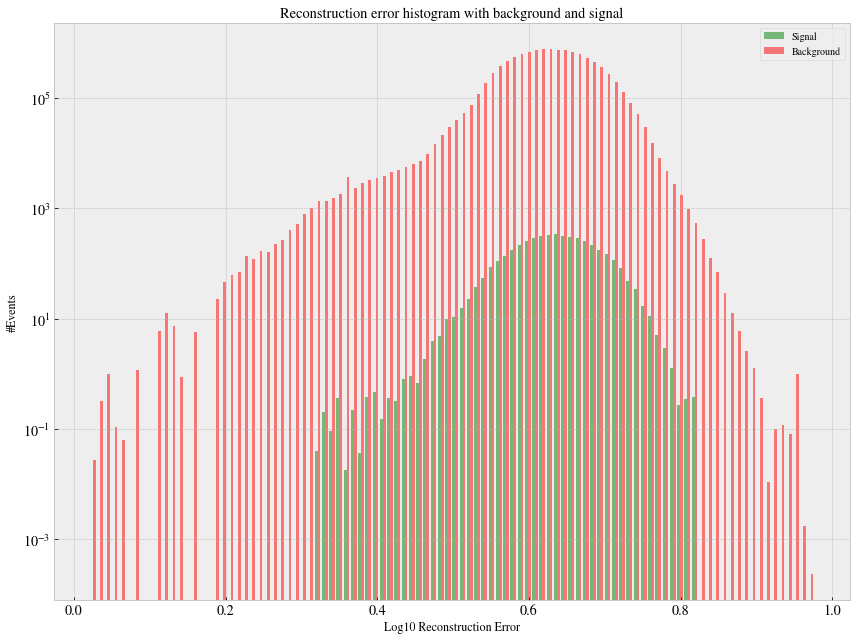

In [62]:
import plot_set

histo_data = [b_s, b]#, norm_recon_data])
weight_histo = [s_test_weights, np.concatenate((b_train_weights, b_val_weights), 0)]

plt.rcParams["figure.figsize"] = (12,9)

fig, ax = plt.subplots()

n_bins= 100
colors = ["green", "red"]
labels= ["Signal", "Background"]
ax.hist(histo_data, 
        n_bins, 
        density=True, 
        stacked=False, 
        alpha=0.5,
        histtype='bar',
        color=colors, 
        label=labels, 
        weights=weight_histo
        )

ax.legend(prop={'size': 10})
ax.set_title('Reconstruction error histogram with background and signal', fontsize=15)
ax.set_xlabel('Log10 Reconstruction Error', fontsize=15)
ax.set_ylabel('#Events', fontsize=15)
ax.set_yscale('log')

fig.tight_layout()
plt.savefig("b_s_recon_small.pdf")
plt.show()

Here we plot the ROC curves for the model

In [58]:
# ROC
Y_b = np.zeros(X_b_val.shape[0]).reshape(X_b_val.shape[0],1);
Y_s = np.ones(X_s_test.shape[0]).reshape(X_s_test.shape[0],1);
Y_ROC = np.concatenate((Y_b, Y_s),0);

sample_weight = np.concatenate((b_val_weights, s_test_weights),0)

Here we plot background against ATLAS data

In [59]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

rec_errors_ROC = np.concatenate((recon_err_back,recon_err_sig),0)

print(recon_err_sig)


fpr, tpr, thresholds = roc_curve(Y_ROC, rec_errors_ROC, sample_weight = sample_weight, pos_label=1)
ae_auc = roc_auc_score(Y_ROC, rec_errors_ROC)
figRocAE, axRocAE = plt.subplots()
figRocAE.set_size_inches(12,12)
axRocAE.plot(fpr, tpr, label='ROC curve')
axRocAE.plot([0, 1], [0, 1], 'k--')
axRocAE.set_xlim([0.0, 1.0])
axRocAE.set_ylim([0.0, 1.05])
axRocAE.set_xlabel('False Anomaly Rate')
axRocAE.set_ylabel('True Anomaly Rate')
axRocAE.text(0.4,0.2,"AUC = %.4f" % ae_auc,fontsize=15)
axRocAE.set_title("Autoencoder ROC")

fig.tight_layout()
plt.savefig("b_s_roc_curve.pdf")
plt.show()

[0.65025608 0.63356266 0.6242118  ... 0.59404494 0.59582671 0.63504207]


ValueError: Found input variables with inconsistent numbers of samples: [12863555, 63777265, 12863555]

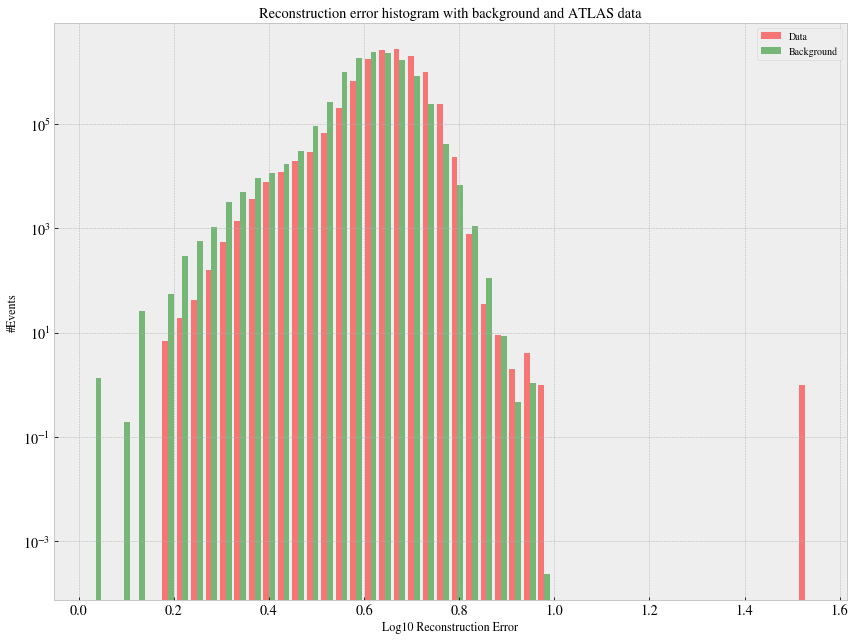

In [61]:
histo_atlas = [norm_recon_data, b]
weight_atlas_data = [data_weights, np.concatenate((b_train_weights, b_val_weights), 0)]


plt.rcParams["figure.figsize"] = (12,9)

fig, ax = plt.subplots()

n_bins= 50
colors = ["red", "green"]
labels= ["Data", "Background"]
ax.hist(histo_atlas, 
        n_bins, 
        density=False, 
        stacked=False, 
        alpha=0.5, 
        histtype='bar', 
        color=colors, 
        label=labels, 
        weights=weight_atlas_data
        )

ax.legend(prop={'size': 10})
ax.set_title('Reconstruction error histogram with background and ATLAS data', fontsize=15)
ax.set_xlabel('Log10 Reconstruction Error', fontsize=15)
ax.set_ylabel('#Events', fontsize=15)
ax.set_yscale('log')

fig.tight_layout()
plt.savefig("b_data_recon_small.pdf")
plt.show()